### Heston Model

The Heston model describes the evolution of a stock price $S_t$ whose variance $V_t$ is given by a mean reverting square root process:

\begin{eqnarray}
\frac{dS_t}{S_t} &=& \mu dt  + \sqrt{V_t}dW_t^{1},\\
dV_t &=& \kappa(\theta - V_t)dt  + \sigma \sqrt{V_t}dW_t^{2}.
\end{eqnarray}

A key characteristic of the model is that the Wiener processes are correlated $dW_t^{1}\cdot dW_t^{2}=\rho dt$. This feature enables the model to exhibit the 'leverage effect'. 

### Jump Diffusion Models: Bates Method

The Bates Jump-Diffusion model [BATES1993] is specified as the following set of coupled stochastic differential equations

\begin{equation}
\frac{dS_t}{S_t} = \mu dt  + \sqrt{V_t}dW_t^{1} + (Y-1)S_tdN_t,
\end{equation}
\begin{equation}
dV_t = \kappa(\theta - V_t)dt  + \sigma \sqrt{V_t}dW_t^{2},
\end{equation}

describing the evolution of a stock price $S_t$ whose variance $V_t$ is given by a mean reverting square root process which ensures that the variance is always positive provided that $2\kappa\theta - \sigma^2>0$. $N_t$ is a standard Poisson process with intensity $\lambda>0$ and $Y$ is the log-normal jump size distribution with mean $\mu_j=ln (1+a) - \frac{\sigma_j^2}{2},~a>-1$ and standard deviation $\sigma_j \geq 0$. 

Both $N(t)$ and $Y$ are independent of the Wiener processes $W_t^{1}$ and $W_t^{2}$.  A key characteristic of the model, which originates from the embedded Heston stochastic volatility diffusion model, is that the Wiener processes are correlated $dW_t^{1}\cdot dW_t^{2}=\rho dt$. This feature enables the model to exhibit the leverage effect. Note that simply excluding the compound Poisson term $(Y-1)S_tdN_t$ recovers the Heston model.

## Pricing
With marginal loss of generality, we will restrict the scope of this section to European equity options. Stochastic volatility models permit semi-analytical closed-form solutions for computing risk neutral European option prices. The price can be represented as a weighted sum of the delta of the European call option $P_1$ and $P_2$ - the probability that the asset price will
exceed the strike price at maturity. Adopting standard option pricing notation, the call price of a vanilla European option is

\begin{equation}
 C(S_0, K,\tau; \mathbf{z}_0) = S_0P_1 - K\exp\{-(r-q )\tau\}P_2,
\end{equation}

$P_1$ and $P_2$ can be expressed as:

\begin{equation}
P_j =\frac{1}{2} + \frac{1}{\pi} \int_{o}^{\infty} \text{Re}\left[\frac{\exp\{-iu ln K\}\phi_j (S_0,\tau,u; \mathbf{z}_0)}{iu}\right]du, j=1,2.
\end{equation}

where $\phi_j$ are Heston analytic characteristic functions and $\mathbf{z}_0$ is the vector of Heston model parameters.  

### Fourier-Cosine Method
An alternative approach to the Carr-Madan FFT approach is to use the Fourier-Cosine Method. Following Fang and Oosterlee [FANG2008], the entire inverse Fourier integral in the pricing equation is reconstructed from Fourier-cosine series expansion of the integrand to give the following approximation of the call price
\begin{equation}
C(S_0, K, \tau; \mathbf{z}_0) \approx Ke^{-r\tau} \cdot \text{Re}\{\sum_{k=0}^{N-1}'\phi\left(\frac{k\pi}{b-a};\mathbf{z}_0\right)e^{ik\pi\frac{x - a}{b-a}}U_k\},
\end{equation}
where $x:= ln(S_0/K)$ and $\phi(w;\mathbf{z}_0)$ denotes the characteristic function of the log-asset price, $U_k$ the payoff series coefficients and $N$ denotes the number of terms in the cosine series expansion (typically 128 will suffice). 

For the approximation of the Heston model call price, the Fourier-Cosine approach is shown to be superior in convergence properties to other FFT and quadrature based methods in [DIXON2013].


<img src="error_convergence.png">

In [1]:
from random import Random
from numpy import *
from scipy import *
from time import *
from datetime import *
import numpy as np
import sys
import csv

%matplotlib inline

In [2]:
### Implement the Fourier-Cosine Method
def HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, otype, N=256):
    c1 = r*T+(1-exp(-lmbda*T))*(meanV-v0)/(2.0*lmbda)-0.5*meanV*T
    c2 = 1.0/(8.0*lmbda**3)*(sigma*T*lmbda*exp(-lmbda*T)*(v0-meanV)*(8.0*lmbda*rho-4.0*sigma)+lmbda*rho*sigma*(1-exp(-lmbda*T))*(16.0*meanV-8.0*v0)+2.0*meanV*lmbda*T*(-4.0*lmbda*rho*sigma+sigma**2+4.0*lmbda**2)+sigma**2*((meanV-2.0*v0)*exp(-2.0*lmbda*T)+meanV*(6.0*exp(-lmbda*T)-7.0)+2.0*v0)+8.0*lmbda**2*(v0-meanV)*(1-exp(-lmbda*T)))
    a = c1-12.0*sqrt(abs(c2))
    b = c1+12.0*sqrt(abs(c2))
    x = log(float(S)/K)
    k = arange(0,N)
    if (otype == 'C'):
       U = 2.0/(b-a)*(xi(k,a,b,0,b) - psi(k,a,b,0,b))
    else:
       U = 2.0/(b-a)*(-xi(k,a,b,a,0) + psi(k,a,b,a,0))   
    unit = [1.0] * N
    unit[0] = 0.5
    ret = 0
# Note that HestonCF is independent of the strike
    HCF = HestonCF(k*pi/(b-a),T,r,sigma,lmbda,meanV,v0,rho)
    for i in range(N):
      ret += unit[i]*HCF[i]*exp(1j*float(k[i])*pi*(x-a)/(b-a))*U[i]
    return K*exp(-r*T)*ret.real

def HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, otype, N=256):
    c1 = r*T+(1-exp(-lmbda*T))*(meanV-v0)/(2.0*lmbda)-0.5*meanV*T
    c2 = 1.0/(8.0*lmbda**3)*(sigma*T*lmbda*exp(-lmbda*T)*(v0-meanV)*(8.0*lmbda*rho-4.0*sigma)+lmbda*rho*sigma*(1-exp(-lmbda*T))*(16.0*meanV-8.0*v0)+2.0*meanV*lmbda*T*(-4.0*lmbda*rho*sigma+sigma**2+4.0*lmbda**2)+sigma**2*((meanV-2.0*v0)*exp(-2.0*lmbda*T)+meanV*(6.0*exp(-lmbda*T)-7.0)+2.0*v0)+8.0*lmbda**2*(v0-meanV)*(1-exp(-lmbda*T)))
    a = c1-12.0*sqrt(abs(c2))
    b = c1+12.0*sqrt(abs(c2))
    x = log(float(S)/K)
    k = arange(0,N)
    if (otype == 'C'):
       U = 2.0/(b-a)*(xi(k,a,b,0,b) - psi(k,a,b,0,b))
    else:
       U = 2.0/(b-a)*(-xi(k,a,b,a,0) + psi(k,a,b,a,0))   
    unit = [1.0] * N
    unit[0] = 0.5
    ret = 0
# Note that HestonCF is independent of the strike
    HCF = HestonCFdu0(k*pi/(b-a),T,r,sigma,lmbda,meanV,v0,rho)
    for i in range(N):
      ret += unit[i]*HCF[i]*exp(1j*float(k[i])*pi*(x-a)/(b-a))*U[i]
    return K*exp(-r*T)*ret.real


def HestonCF(u,T,r,sigma,lmbda,meanV,v0,rho):
    a = lmbda*meanV
    b = lmbda
    d = sqrt((1j*rho*sigma*u-b)**2+(u**2+1j*u)*sigma**2)
    g = (b-1j*rho*sigma*u-d)/(b-1j*rho*sigma*u+d)
    ret = exp(1j*u*r*T)
    ret = ret*exp((a/sigma**2)*((b - rho*1j*sigma*u - d)*T - 2.0*log((1-g*exp(-d*T))/(1-g))))
    return ret*exp((v0/sigma**2)*(b - rho*1j*sigma*u - d)*(1-exp(-d*T))/(1-g*exp(-d*T)))


# The Derivative of the Heston Characteristic Function w.r.t. to the v0 
def HestonCFdu0(u,T,r,sigma,lmbda,meanV,v0,rho):

    a = lmbda*meanV
    b = lmbda
    d = sqrt((1j*rho*sigma*u-b)**2+(u**2+1j*u)*sigma**2)
    g = (b-1j*rho*sigma*u-d)/(b-1j*rho*sigma*u+d)
    ret = exp(1j*u*r*T)
    
    ret = ret*exp((a/sigma**2)*((b - rho*1j*sigma*u - d)*T - 2.0*log((1.0-g*exp(-d*T))/(1.0-g))))
    ret = ret*exp((v0/sigma**2)*(b - rho*1j*sigma*u - d)*(1.0-exp(-d*T))/(1.0-g*exp(-d*T)))
    ret = ret *((1.0-exp(-d*T))/(1.0-g*exp(-d*T)))*(b-1j*rho*sigma*u-d)/(sigma**2)
    return(ret)



def xi(k,a,b,c,d):
    ret = 1.0/(1+(k*pi/(b-a))**2)*(cos(k*pi*(d-a)/(b-a))*exp(d)-cos(k*pi*(c-a)/(b-a))*exp(c)+k*pi/(b-a)*sin(k*pi*(d-a)/(b-a))*exp(d)-k*pi/(b-a)*sin(k*pi*(c-a)/(b-a))*exp(c))
    return ret

def psi(k,a,b,c,d):
    N = len(k)
    idx = arange(1, N)
    ret = array([0.0]*N)
    ret[0] = d-c
    ret[idx] =(sin(k[idx]*pi*(d-a)/(b-a))-sin(k[idx]*pi*(c-a)/(b-a)))*(b-a)/(k[idx]*pi)
    return ret



In [3]:
import matplotlib.pyplot as plt

In [229]:
nInt = 256
r0 = 0.0002

#p0 = [5.76145232379, 0.393696857573, 0.99999999,-0.686387364593,0.685888435264]
#print Error_Function(p0)

S= 100
K = 100
T = 0.01
r = r0
sigma = 0.6
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho =-0.9
V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

vegas = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
  vegas.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt));


Text(0,0.5,'vegas')

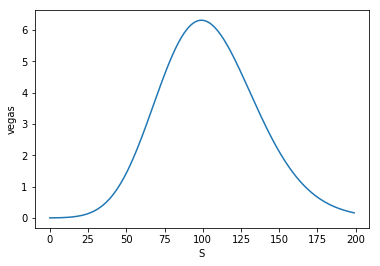

In [5]:
plt.plot(vegas)
plt.xlabel('S')
plt.ylabel('vegas')

What if we just fit the regression to a smaller number of points

In [6]:
idx = np.arange(1,len(S_arr),40)

In [7]:
rg = np.polyfit(S_arr[idx], np.array(vegas)[idx], 4)
vegas_reg = np.polyval(rg, S_arr[idx])  # continuation values

S_arr[idx], np.array(vegas)[idx], vegas_reg

(array([  90.1,   94.1,   98.1,  102.1,  106.1]),
 array([  3.06921759e-03,   7.22017269e-01,   5.28408471e+00,
          5.05346261e+00,   1.32383761e+00]),
 array([  3.06921770e-03,   7.22017269e-01,   5.28408471e+00,
          5.05346261e+00,   1.32383761e+00]))

Text(0,0.5,'vegas')

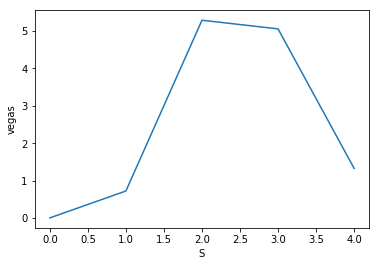

In [8]:
plt.plot(vegas_reg)
plt.xlabel('S')
plt.ylabel('vegas')

What if I fit polynomial regression

In [9]:
x = S_arr[idx]
y = np.array(vegas)[idx]
p3=np.polyfit(x, y, 3)
p3_test = np.polyval(np.polyfit(x, y, 3), x)

In [10]:
def p3_func(x):
    ret = p3[0] * (x**3) + p3[1] * (x**2) + p3[2] * x + p3[3]
    return ret

In [11]:
poly_reg = []
for S in S_arr[idx]:
    poly_reg.append(p3_func(S))

Text(0,0.5,'vegas')

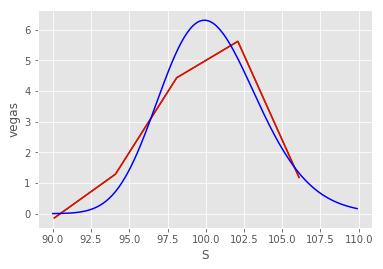

In [224]:
plt.plot(S_arr[idx], poly_reg, color='g') # calculated by p3_func above, overlapped with plot by np.polyval(...), same result.
plt.plot(S_arr[idx], p3_test, color = 'r') # calculated by np.polyval(...)
plt.plot(S_arr, vegas, color = 'b') 
plt.xlabel('S')
plt.ylabel('vegas')

(-2, 10)

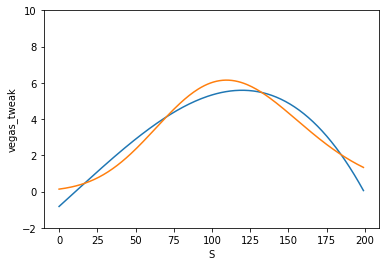

In [13]:
# tweak parameters
S= 100
K = 101
T = 0.014
r = r0
sigma = 0.5
lmbda = 0.1
meanV = 0.1
v0 = 0.15
rho =-0.9
V= HestonCOS(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

vegas_tweak = []
S_arr = np.arange(90,110,0.1)
for S in S_arr:
    vegas_tweak.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt));

p3_tweak = np.polyval(np.polyfit(S_arr, np.array(vegas_tweak), 3), S_arr)

plt.plot(p3_tweak)
plt.plot(vegas_tweak)
plt.xlabel('S')
plt.ylabel('vegas_tweak')
plt.ylim(-2,10)

Apply GPR 

In [15]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')
from edward.models import MultivariateNormalTriL
from edward.util import rbf

In [214]:
# Numerical prediction
sess = ed.get_session()

x_train32 = np.array(S_arr, dtype='float32').reshape(200,1)
x_test32 = np.array(S_arr[idx], dtype='float32').reshape(5,1)
test_y = np.array(vegas)[idx]

K = rbf(x_train32).eval()
K_noise = K + np.eye(len(vegas)) #*(1e-1)  
k_s = rbf(x_train32).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, vegas))
predict_mean = np.dot(k_s, alpha)

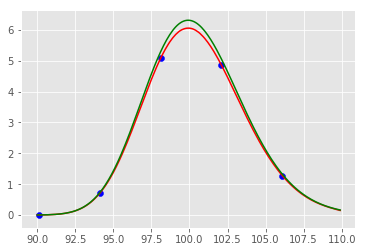

In [215]:
plt.plot(S_arr, predict_mean, color = 'red')
plt.plot(S_arr, vegas, color = 'green')
plt.scatter(S_arr[idx], predict_mean[idx], color = 'b')

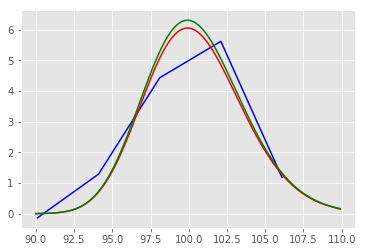

In [226]:
plt.plot(S_arr[idx], p3_test, color = 'b')
plt.plot(S_arr, predict_mean, color = 'red')
plt.plot(S_arr, vegas, color = 'green')

In [176]:
mse = []

In [207]:
# Convergency check with multiple training sets
n_train = 1000
training_x = np.linspace(90,110, n_train)
training_y = []
for S in training_x:
    training_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

In [208]:
testing_x = np.linspace(95,105, n_train)
testing_y = []
for S in testing_x:
    testing_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))

In [209]:
train32_x = np.array(training_x, dtype='float32').reshape(n_train,1)
test32_x = np.array(testing_x, dtype='float32').reshape(n_train,1)

Kernel = rbf(train32_x).eval()
K_noise = Kernel + np.eye(n_train) # *0.1
k_s = rbf(test32_x, train32_x).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, training_y))
predict = np.dot(k_s, alpha)

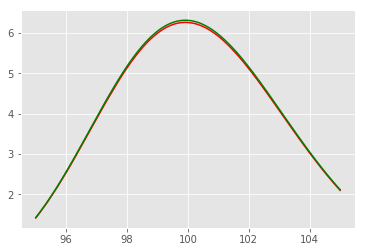

In [210]:
plt.plot(testing_x, predict, color = 'red')
plt.plot(testing_x, testing_y, color = 'green')

In [211]:
mse.append(np.mean((predict - testing_y )**2)) # trying to use function but errors occur, it takes some time to fix, just plot by mannual repeat for now
mse

[0.43994371114951519,
 0.12622571159886223,
 0.059036180480466008,
 0.033999226123492148,
 0.022073386925422996,
 0.0056969470351026846,
 0.0014509991054503218]

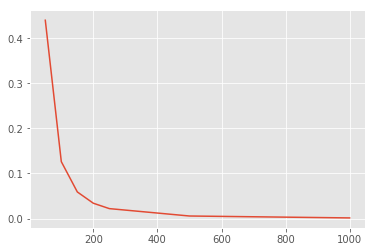

In [212]:
n_training = np.array([50, 100, 150, 200, 250, 500, 1000])   # convergency plot against number of training set
plt.plot(n_training, mse) 

In [227]:
def converge(n_train):
    mse = []
    for n in n_train:
        training_x = np.linspace(90,110, n)
        training_y = []
        for S in training_x:
            training_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
        
        testing_x = np.linspace(95,105, n)
        testing_y = []
        for S in testing_x:
            testing_y.append(HestonVega(S,K,T,r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt))
            
        train32_x = np.array(training_x, dtype='float32').reshape(n,1)
        test32_x = np.array(testing_x, dtype='float32').reshape(n,1)
        Ker = rbf(train32_x).eval()
        K_noise = Ker+ np.eye(n_train) # *0.1
        k_s = rbf(test32_x, train32_x).eval()                   
        L = np.linalg.cholesky(K_noise)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, training_y))
        predict_mean = np.dot(k_s, alpha)
        
        mse.append(np.mean((predict_mean - testing_y )**2))
    
    return mse

In [230]:
converge(n_training)

TypeError: only integer scalar arrays can be converted to a scalar index

In [17]:
#GPR WITH EDWARD
# Initiate dataset
i = np.arange(200)[0:200:2]
j = np.arange(200)[1:200:2]
x_train = S_arr[i].reshape(100,1)
y_train = np.array(vegas)[i]
x_test = S_arr[j].reshape(100,1)
y_test = np.array(vegas)[j]



In [18]:
n = 100
d = 1
qw = Normal(loc=tf.get_variable("qw/loc", [d]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [d])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

In [19]:
X = tf.placeholder(tf.float32, [n, d])
w = Normal(loc=tf.zeros(d), scale=tf.ones(d))
b = Normal(loc=tf.zeros(1.), scale=tf.ones(1.))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(n))

In [20]:
inference = ed.KLqp({w : qw, b: qb}, data={X: x_train, y: y_train})
inference.run(n_samples=10, n_iter=4000)

4000/4000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 352.327


In [21]:
post_q = qw.mean().eval() # if this is the right way of finding w, then which is which? 
post_b = qb.mean().eval() 

array([-0.41227898], dtype=float32)

In [22]:
#criticism
y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(n))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: x_test, y_post: y_test}))

Mean squared error on test data:
4.87043
Mean absolute error on test data:
1.98387


In [23]:
def visualise(x_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  #plt.scatter(x_data, y_data)
  inputs = np.linspace(-10,10, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

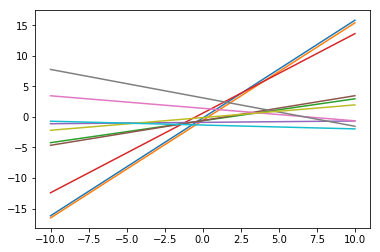

In [24]:
visualise(x_train, y_train, w, b)

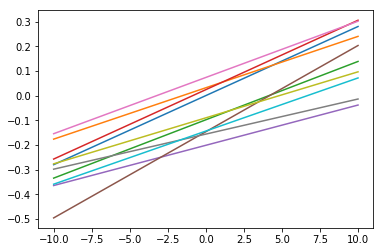

In [25]:
visualise(x_test, y_test, qw, qb)

fit GP with input [S_i, T_i]，   T_i fixed

In [26]:
T = 0.01 #fixed
x_train_2d = np.arange(200).reshape(100,2)
x_test_2d = np.arange(200).reshape(100,2)
for i in range(100):
    x_train_2d[i] = [x_train[i], T]
    x_test_2d[i] = [x_test[i], T]

In [27]:
n = 100
dim = 2
qw_2d = Normal(loc=tf.get_variable("qw/Lo", [dim]),
            scale=tf.nn.softplus(tf.get_variable("qw/Sc", [dim])))
qb_2d = Normal(loc=tf.get_variable("qb/Lo", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/Sc", [1])))

X_2d = tf.placeholder(tf.float32, [n, dim])
w = Normal(loc=tf.zeros(dim), scale=tf.ones(dim))
b = Normal(loc=tf.zeros(1.), scale=tf.ones(1.))
y = Normal(loc=ed.dot(X_2d, w) + b, scale=tf.ones(n))

In [28]:
inference = ed.KLqp({w : qw_2d, b: qb_2d}, data={X_2d: x_train_2d, y: y_train})
inference.run(n_samples=15, n_iter=4000)

4000/4000 [100%] ██████████████████████████████ Elapsed: 15s | Loss: 489.876


In [29]:
#criticism
y_post_2d = Normal(loc=ed.dot(X_2d, qw_2d) + qb_2d, scale=tf.ones(n))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X_2d: x_test_2d, y_post_2d: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X_2d: x_test_2d, y_post_2d: y_test}))

Mean squared error on test data:
4.91929
Mean absolute error on test data:
1.96726


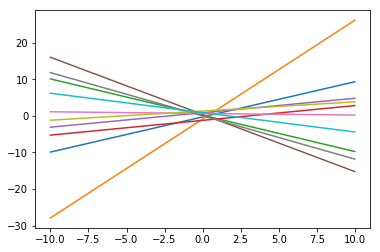

In [30]:
visualise(x_train, y_train, w, b)

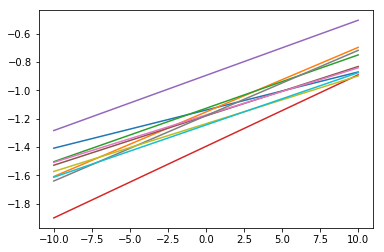

In [31]:
visualise(x_test, y_test, qw_2d, qb_2d)

In [41]:
x_train[9]

array([ 91.8])

Varying T

In [32]:
# Initiate datasets
T_vary = np.linspace(0.01,1,200)
T_train = T_vary[i]
T_test = T_vary[j]


In [86]:
i = np.arange(200)[0:200:2]
j = np.arange(200)[1:200:2]
x_train_3d = np.arange(200).reshape(100,2)
x_test_3d = np.arange(200).reshape(100,2)
y_train_3d = np.arange(100)
y_test_3d = np.arange(100)

for m in range(100):
    x_train_3d[m] = [ x_train[m] , T_train[m] ] 
    x_test_3d[m] =  [ x_test[m] , T_test[m] ] 

for n in range(100):
    y_train_3d[n] = HestonVega(x_train[n], K, T_train[n], r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)
    y_test_3d[n] = HestonVega(x_test[n], K, T_test[n], r,sigma,lmbda,meanV,v0,rho, 'C', N=nInt)

IndexError: invalid index to scalar variable.

In [150]:
# Inference
n = 100
d3 = 2
qw_3d = Normal(loc=tf.get_variable("qw/3dlo", [d3]),
            scale=tf.nn.softplus(tf.get_variable("qw/3dsc", [d3])))
qb_3d = Normal(loc=tf.get_variable("qb/3dlo", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/3dsc", [1])))

X_3d = tf.placeholder(tf.float32, [n, d3])
w = Normal(loc=tf.zeros(d3), scale=tf.ones(d3))
b = Normal(loc=tf.zeros(1.), scale=tf.ones(1.))
y = Normal(loc=ed.dot(X_3d, w) + b, scale=tf.ones(n))

In [157]:
inference = ed.KLqp({w : qw_3d, b: qb_3d}, data={X_3d: x_train_3d, y: y_train_3d})
inference.run(n_samples=15, n_iter=4000)

4000/4000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 249157.328


In [158]:
#criticism
y_post_3d = Normal(loc=ed.dot(X_3d, qw_3d) + qb_3d, scale=tf.ones(n))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X_3d: x_test_3d, y_post_3d: y_test_3d}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X_3d: x_test_3d, y_post_3d: y_test_3d}))

Mean squared error on test data:
5242.54
Mean absolute error on test data:
54.0253


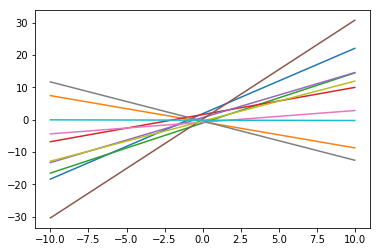

In [237]:
visualise(x_train, y_train, w, b)

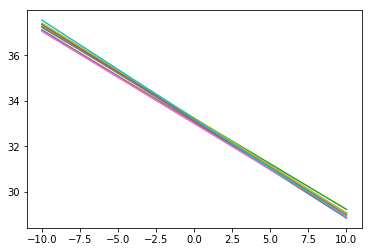

In [262]:
visualise(x_test, y_test, qw_3d, qb_3d)

(array([  2.,   1.,   1.,   1.,   1.,   6.,   6.,   7.,  10.,   9.,   7.,
          7.,  16.,   5.,   5.,   4.,   5.,   4.,   2.,   1.]),
 array([-0.14841175,  0.09326153,  0.33493481,  0.57660809,  0.81828136,
         1.05995464,  1.30162792,  1.5433012 ,  1.78497448,  2.02664776,
         2.26832104,  2.50999432,  2.75166759,  2.99334087,  3.23501415,
         3.47668743,  3.71836071,  3.96003399,  4.20170727,  4.44338055,
         4.68505383]),
 <a list of 20 Patch objects>)

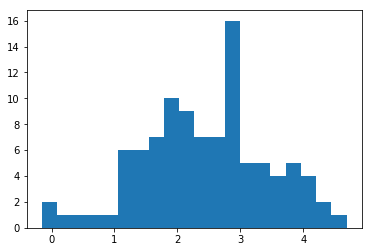

In [97]:
sess = ed.get_session()
y_post_2d_test = Normal(loc=ed.dot(X_2d, qw_2d) + qb_2d, scale=tf.ones(n))
p = sess.run(y_post_2d_test, feed_dict={X_2d : x_test_2d})  # cannot customize number of samplers
plt.hist(p, bins=20) # how to plot density line?

GP regression w.r.t [S_i] and [S_i, T_fixed] work well, the criticism part indicates relatively small errors, both linear relationship has been improved . the regression w.r.t [S_i, T_vary] also works, linear relationship has been improved significantly.